# Session 11: Decision Tree with Grid Search

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from  sklearn.metrics import roc_auc_score, roc_curve,recall_score

In [2]:
data=pd.read_excel("Affairs.xlsx")

In [3]:
#no variable with 0 variance
data.var()

ID               837050.447659
affairs               0.187604
age                  86.281094
yearsmarried         31.039419
religiousness         1.363078
education             5.772268
occupation            3.310372
rating                1.217005
dtype: float64

In [4]:
#no missing values
data.isnull().sum()

ID               0
affairs          0
gender           0
age              0
yearsmarried     0
children         0
religiousness    0
education        0
occupation       0
rating           0
dtype: int64

In [5]:
#let's drop ID
data.drop("ID",axis=1,inplace=True)

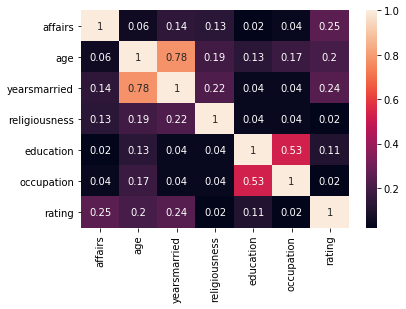

In [6]:
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

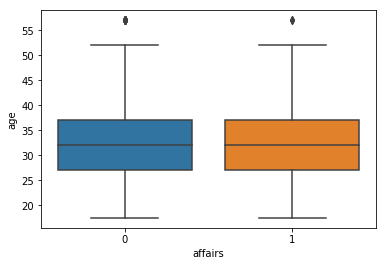

In [7]:
sns.boxplot(data.affairs,data.age)
plt.show()

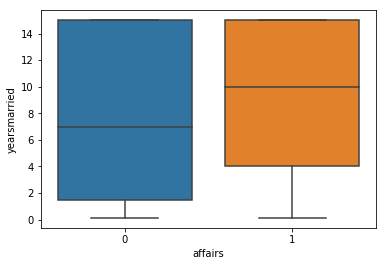

In [8]:
sns.boxplot(data.affairs,data.yearsmarried)
plt.show()

In [9]:
#let's drop age
data.drop("age",axis=1,inplace=True)

In [10]:
#let's get dummy variables frim object type variables, otherwise sklearn will give error while running DT
data=pd.get_dummies(data,drop_first=True)

In [11]:
#devide the data into X and Y subsets
#do train and test split
Y=data.affairs
X=data.drop("affairs",axis=1)
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [12]:
Y.value_counts()/len(Y)*100

0    75.041597
1    24.958403
Name: affairs, dtype: float64

# Fully Grown Decision Tree

In [13]:
#let's grow the tree fully which overfits the train data
tree1=DecisionTreeClassifier(random_state=42)
tree1.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [14]:
print("ROC_AUC",roc_auc_score(y_train,tree1.predict(x_train)),
roc_auc_score(y_test,tree1.predict(x_test)))
print("Accuracy",tree1.score(x_train,y_train),
tree1.score(x_test,y_test))

ROC_AUC 0.9469026548672566 0.5211000474158368
Accuracy 0.9733333333333334 0.6490066225165563


# Finding optimal parameters for DT with GridSearchCV

In [15]:
#let's get optimal parameters in specified ranges
gridsearch=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid={
                        "class_weight":[None,"balanced"],'max_depth':(5,10),
                        "min_samples_leaf":(25,150,10)
                    },cv=5,scoring="roc_auc",n_jobs=-1).fit(x_train,y_train)

In [16]:
#let's see the optimal parameters
gridsearch.best_params_

{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 25}

In [17]:
#the mean roc_auc score for train data based on gridsearchcv results
gridsearch.best_score_

0.6633009736252474

In [18]:
#let's construct DT with the best parameters 
tree2=DecisionTreeClassifier(class_weight='balanced', max_depth=5, 
                             min_samples_leaf=25,random_state=42).fit(x_train,y_train)

In [19]:
print("roc_auc:",roc_auc_score(y_train,tree2.predict(x_train)),
                  roc_auc_score(y_test,tree2.predict(x_test)))

roc_auc: 0.6895564717313096 0.6211474632527264


In [20]:
print("recall",recall_score(y_train,tree2.predict(x_train)),
            recall_score(y_test,tree2.predict(x_test)))

recall 0.6194690265486725 0.5405405405405406


In [21]:
print("accuracy",tree2.score(x_train,y_train),
      tree2.score(x_test,y_test))

accuracy 0.7244444444444444 0.6622516556291391


In [22]:
#let's find cross validation score for the tree2
cv_scores=cross_val_score(tree2,X,Y,cv=8,scoring="roc_auc",n_jobs=-1)
cv_scores

array([0.57710065, 0.54662973, 0.62234534, 0.74107143, 0.60009398,
       0.81296992, 0.61210317, 0.59474206])

In [23]:
#mean cross vildation score
np.mean(cv_scores)

0.638382036505738

In [24]:
#feature importances of the winning model
tree2.feature_importances_

array([0.07341311, 0.20921986, 0.10637582, 0.00639193, 0.5483956 ,
       0.        , 0.05620369])

In [25]:
feat_imp=pd.DataFrame(tree2.feature_importances_,index=X.columns,
                      columns=["Feature_imp"])
feat_imp=feat_imp.sort_values(by="Feature_imp",ascending=False)
feat_imp

,Feature_imp
rating,0.548396
religiousness,0.209220
education,0.106376
yearsmarried,0.073413
children_yes,0.056204
occupation,0.006392
gender_male,0.000000


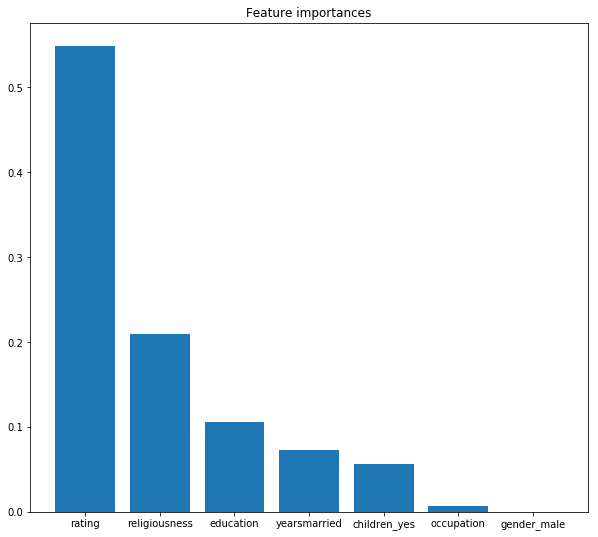

In [26]:
plt.figure(figsize=(10,9))
plt.bar(feat_imp.index,feat_imp.Feature_imp)
plt.title("Feature importances")
plt.show()